In [ ]:
!git clone https://github.com/GKPr0/Self-Driving-Car-Simulation.git 

fatal: destination path 'Self-Driving-Car-Simulation' already exists and is not an empty directory.


In [ ]:
!pip install imgaug

In [ ]:
import os
import cv2
import ntpath
import random
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa


In [ ]:
# Loading training data labels
data_dir = 'Self-Driving-Car-Simulation/Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse','speed']
data = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

center  ...     speed
0  /home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_522.jpg  ...  0.000078
1  /home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_624.jpg  ...  0.000081
2  /home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_739.jpg  ...  0.000078
3  /home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_857.jpg  ...  0.000078
4  /home/formule1/Self-Driving-Car-Simulation/Data/IMG/center_2020_11_22_18_26_19_971.jpg  ...  0.000079

[5 rows x 7 columns]

In [ ]:
# Extracting img name from img path
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

center  ...     speed
0  center_2020_11_22_18_26_19_522.jpg  ...  0.000078
1  center_2020_11_22_18_26_19_624.jpg  ...  0.000081
2  center_2020_11_22_18_26_19_739.jpg  ...  0.000078
3  center_2020_11_22_18_26_19_857.jpg  ...  0.000078
4  center_2020_11_22_18_26_19_971.jpg  ...  0.000079

[5 rows x 7 columns]

In [ ]:
# Optimize steering angle distibution by setting maximum number of records for each angle
remove_list = []

num_bins = 25
samples_per_bin = 400

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5

print('total data', len(data))

for i in range(num_bins):
  list_ = []
  for j in range(len(data['steering'])):
    if data['steering'][j] >= bins[i] and data['steering'][j] <= bins[i+1]:
      list_.append(j)

  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))

data.drop(data.index[remove_list], inplace=True)

print("remaining data:", len(data))

hist_new, _ = np.histogram(data['steering'], num_bins)



total data 5487
removed 3797
remaining data: 1690


In [ ]:
# Loading training images and assigning them to appropriate steering angle
def load_img_steering(data_dir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0:3]
    image_path.append(os.path.join(data_dir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)

  return image_paths, steerings

image_paths, steerings = load_img_steering(data_dir + '/IMG', data)

In [ ]:
# Splitting data to training and validation set
X_train_raw, X_val_raw, Y_train_raw, Y_val_raw = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print("Training sample: {} \n Valid samples: {}".format(len(X_train_raw), len(X_val_raw)))

Training sample: 1352 
 Valid samples: 338


In [ ]:
# Dataset augmentation
def zoom(img):
  zoom = iaa.Affine(scale=(1, 1.3))
  img = zoom.augment_image(img)
  return img

def translate(img):
  translate = iaa.Affine(translate_percent={"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  img = translate.augment_image(img)
  return img

def img_random_brightness(img):
  brightness = iaa.Multiply((0.2, 1.2))
  img = brightness.augment_image(img)
  return img

def img_random_flip(img, steering_angle):
  img = cv2.flip(img, 1)
  steering_angle = -steering_angle
  return img, steering_angle

# Applies filters with 50% change each
def random_augment(img, steering_angle):
  img = mpimg.imread(img)

  if np.random.rand() < 0.5:
    img = translate(img)
  if np.random.rand() < 0.5:
    img = zoom(img)
  if np.random.rand() < 0.5:
    img = img_random_brightness(img)
  if np.random.rand() < 0.5:
    img, steering_angle = img_random_flip(img, steering_angle)

  return img, steering_angle


In [ ]:
# Preprocessing images
def img_preprocess(img):
  img = img[60:136, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img / 255
  return img
  

In [ ]:
# Batch generator
def batch_generator(image_paths, steering_angle, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        img, steering = random_augment(image_paths[random_index], steering_angle[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_angle[random_index]

      img = img_preprocess(img)

      batch_img.append(img)
      batch_steering.append(steering)
    
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
# Creating Nvidia model
model = Sequential()

model.add(Convolution2D(24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='relu'))
model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
model.add(Convolution2D(64, kernel_size=(3, 3), activation='elu'))
model.add(Convolution2D(64, kernel_size=(3, 3), activation='elu'))
#model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu'))
#model.add(Dropout(0.5))

model.add(Dense(50, activation='elu'))
#model.add(Dropout(0.5))

model.add(Dense(10, activation='elu'))
#model.add(Dropout(0.5))

model.add(Dense(1))

optimizer = Adam(lr=1e-4)

model.compile(optimizer, loss='mse')

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)              

In [ ]:
# Train model
history = model.fit(batch_generator(X_train_raw, Y_train_raw, batch_size=100, istraining=True),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=batch_generator(X_val_raw, Y_val_raw, batch_size=100, istraining=False),
                    validation_steps=200,
                    verbose=1,
                    shuffle=1)


Epoch 1/10
300/300 [==============================] - 168s 561ms/step - loss: 0.0650 - val_loss: 0.0365
Epoch 2/10
300/300 [==============================] - 170s 566ms/step - loss: 0.0490 - val_loss: 0.0373
Epoch 3/10
300/300 [==============================] - 169s 564ms/step - loss: 0.0460 - val_loss: 0.0362
Epoch 4/10
300/300 [==============================] - 169s 564ms/step - loss: 0.0447 - val_loss: 0.0368
Epoch 5/10
300/300 [==============================] - 170s 566ms/step - loss: 0.0427 - val_loss: 0.0343
Epoch 6/10
300/300 [==============================] - 171s 568ms/step - loss: 0.0416 - val_loss: 0.0337
Epoch 7/10
300/300 [==============================] - 169s 563ms/step - loss: 0.0413 - val_loss: 0.0329
Epoch 8/10
300/300 [==============================] - 170s 567ms/step - loss: 0.0400 - val_loss: 0.0332
Epoch 9/10
300/300 [==============================] - 169s 565ms/step - loss: 0.0396 - val_loss: 0.0347
Epoch 10/10
300/300 [==============================] - 170s 565m

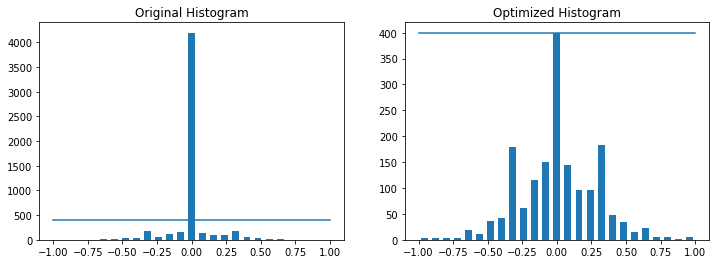

In [ ]:
# Plotting steering angle distribution before and after optimalization
fig, axs = plt.subplots(1,2, figsize=(12, 4))

axs[0].set_title("Original Histogram")
axs[0].bar(center, hist, width=0.05)
axs[0].plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

axs[1].set_title("Optimized Histogram")
axs[1].bar(center, hist_new, width=0.05)
axs[1].plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Text(0.5, 1.0, 'Validation set')

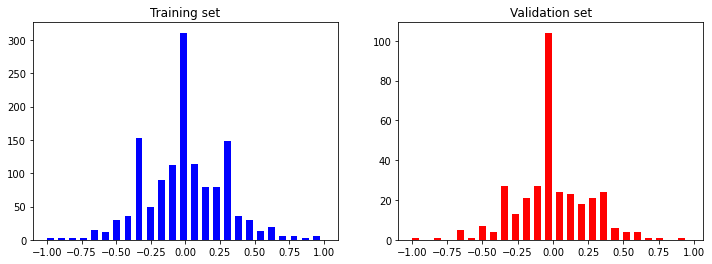

In [ ]:
# Plotting steering angle distibution in train and val dataset
fig, axs = plt.subplots(1,2, figsize=(12, 4))

axs[0].hist(Y_train_raw, bins=num_bins, width=0.05, color='b')
axs[0].set_title("Training set")

axs[1].hist(Y_val_raw, bins=num_bins, width=0.05, color='r')
axs[1].set_title("Validation set")

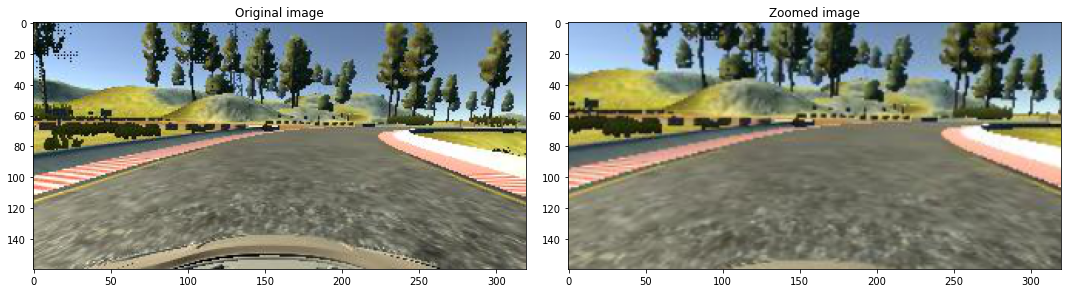

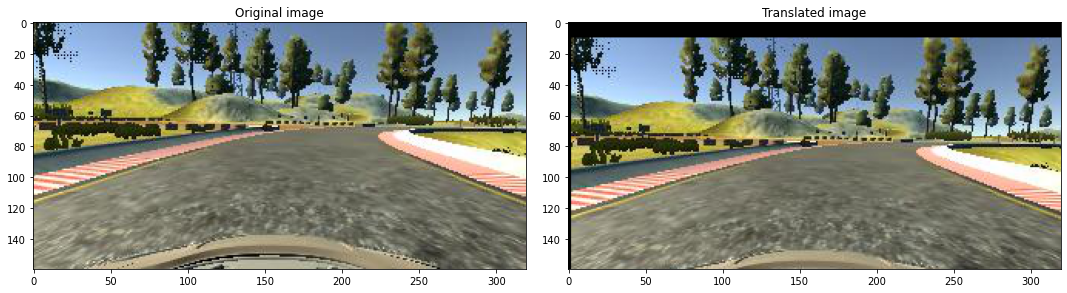

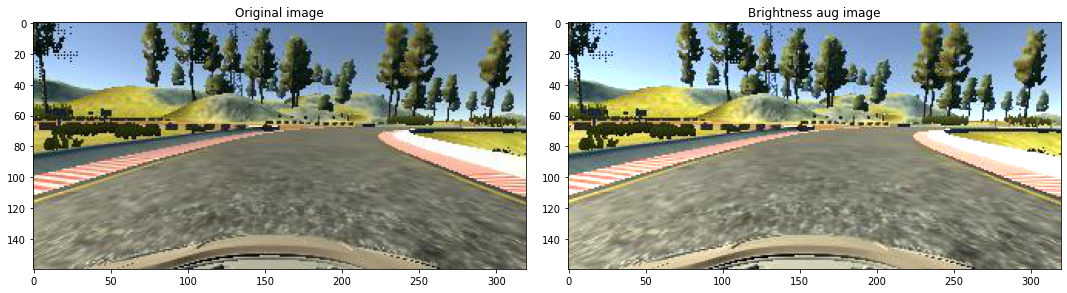

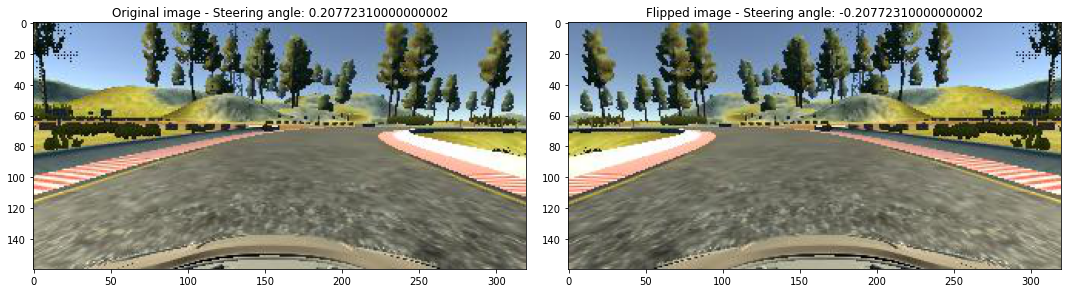

In [ ]:
# Plotting applied techniques in augmentation
random_index = random.randint(0, len(image_paths) -1)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_img = mpimg.imread(image)
zoomed_img = zoom(original_img)
translated_img = translate(original_img)
brightness_img = img_random_brightness(original_img)
flipped_img, flipped_steering_angle = img_random_flip(original_img, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].set_title("Original image")
axs[0].imshow(original_img)

axs[1].set_title("Zoomed image")
axs[1].imshow(zoomed_img)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].set_title("Original image")
axs[0].imshow(original_img)

axs[1].set_title("Translated image")
axs[1].imshow(translated_img)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].set_title("Original image")
axs[0].imshow(original_img)

axs[1].set_title("Brightness aug image")
axs[1].imshow(brightness_img)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].set_title("Original image - Steering angle: {}".format(steering_angle))
axs[0].imshow(original_img)

axs[1].set_title("Flipped image - Steering angle: {}".format(flipped_steering_angle))
axs[1].imshow(flipped_img)

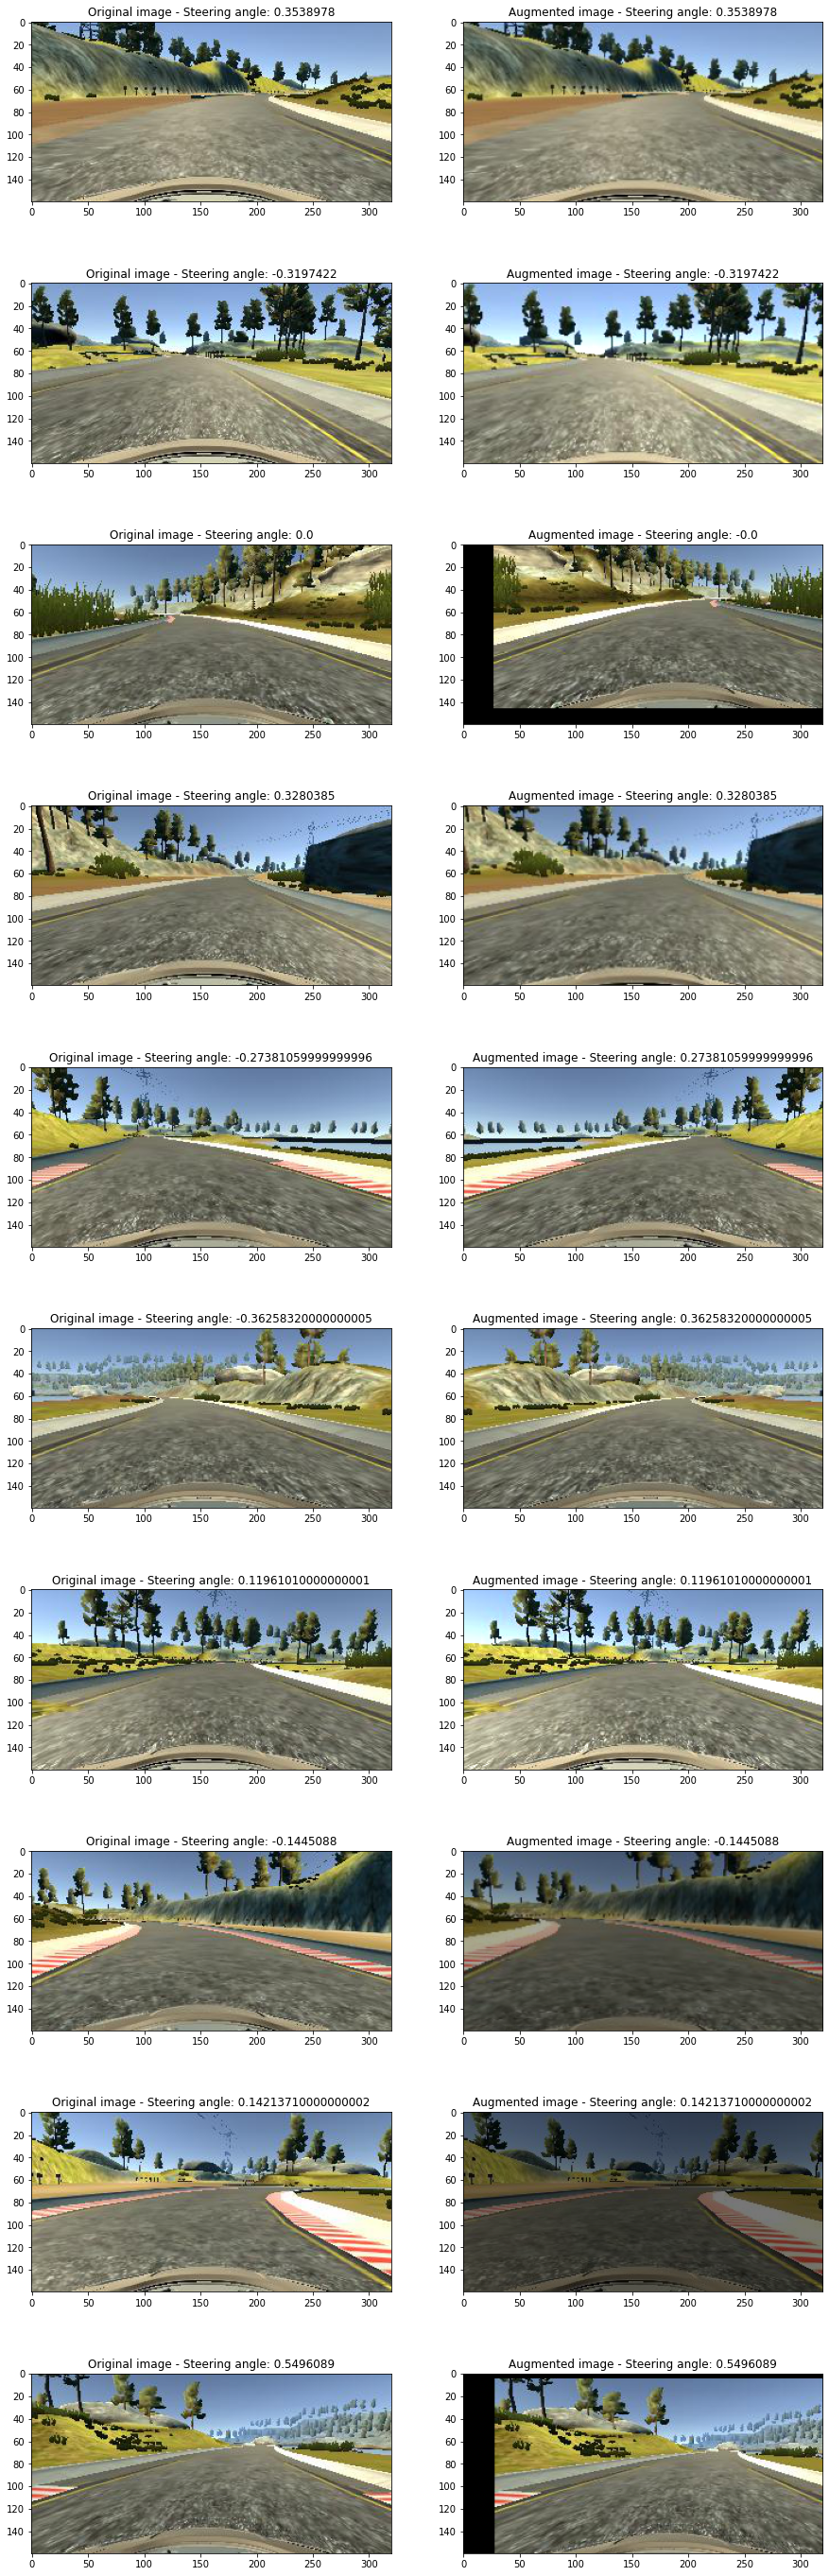

In [ ]:
# Plotting random examples of augmentation
ncol = 2
nrow = 10

fix, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
  random_index = random.randint(0, len(image_paths) -1)
  random_img = image_paths[random_index]
  random_steering = steerings[random_index]

  original_img = mpimg.imread(random_img)
  augmented_img, steering_angle = random_augment(random_img, random_steering)

  axs[i][0].set_title("Original image - Steering angle: {}".format(random_steering))
  axs[i][0].imshow(original_img)

  axs[i][1].set_title("Augmented image - Steering angle: {}".format(steering_angle))
  axs[i][1].imshow(augmented_img)

Text(0.5, 1.0, 'Preprocessed Image Shape:(66, 200, 3)')

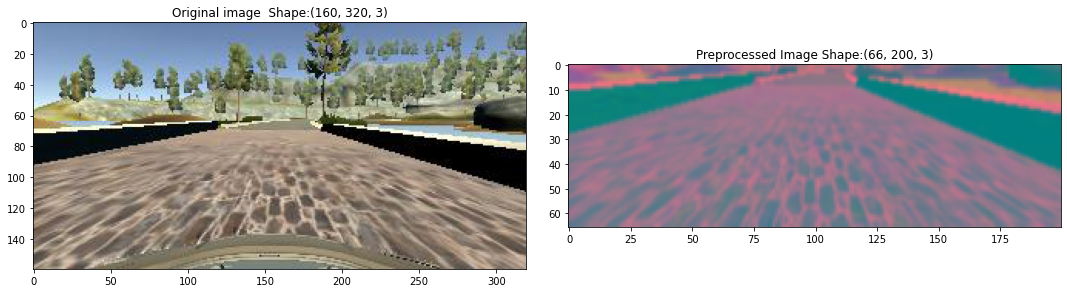

In [124]:
# Plotting Image before and after preprocessing
img_index = random.randint(0, len(X_train_raw)-1)
original_img = mpimg.imread(X_train_raw[img_index])
preprocessed_img = img_preprocess(original_img) 

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title("Original image  Shape:{}".format(original_img.shape))

axs[1].imshow(preprocessed_img)
axs[1].set_title("Preprocessed Image Shape:{}".format(preprocessed_img.shape))

Text(0.5, 1.0, 'Train loss vs Validation loss')

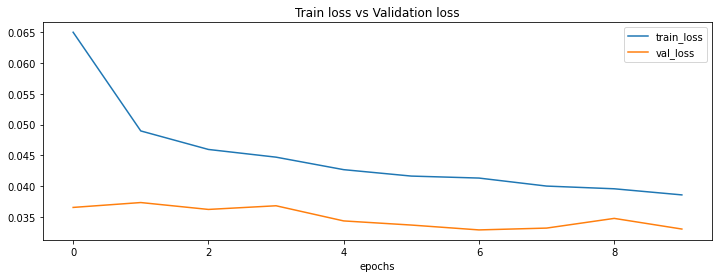

In [ ]:
# Plotting model loss
plt.figure(figsize=(12, 4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train_loss", "val_loss"])
plt.xlabel("epochs")
plt.title("Train loss vs Validation loss")

In [ ]:
# Save model
model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>